In [1]:
import kagglehub
import os
import shutil
import random
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil

In [2]:
# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits


In [3]:
# Get the actual path from the kagglehub download
dataset_base = Path("/kaggle/input/fruits")
training_path = dataset_base / "fruits-360_100x100/fruits-360/Training"

# First, let's see what classes are actually available
print("Available fruit classes:")
available_classes = sorted(os.listdir(training_path))
print(f"Total classes: {len(available_classes)}")
print(f"Sample classes: {available_classes[:10]}...")

# More specific target classes
target_classes = ["Dates", "Banana", "Orange"]

# Find the best matches for our target classes, but only take the first match
selected_classes = {}
for target in target_classes:
    matches = [cls for cls in available_classes if target.lower() in cls.lower()]
    if matches:
        # Just take the first match for each target class
        selected_classes[matches[0]] = target.lower().replace(" ", "").replace("red", "")
        print(f"Found match for {target}: {matches[0]}")

print(f"Selected classes: {selected_classes}")

# Folder output
output_base = Path("/content/fruits_dataset")

# We want 11,000 total images
total_images = 11000
# Calculate per-class images (evenly distributed)
images_per_class = total_images // len(selected_classes)

# Distribution ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

def prepare_dataset():
    total_processed = 0

    for old_class, new_class in selected_classes.items():
        src = training_path / old_class

        # Check if the source directory exists
        if not os.path.exists(src):
            print(f"Warning: Source directory not found: {src}")
            continue

        images = list(src.glob("*.jpg"))
        print(f"Found {len(images)} images in {old_class}")

        if not images:
            print(f"No images found in {src}")
            continue

        # If we have more images than needed, select randomly
        if len(images) > images_per_class:
            random.shuffle(images)
            images = images[:images_per_class]
            print(f"Selected {len(images)} images from {old_class}")

        total_processed += len(images)

        # Split according to ratios
        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            target_dir = output_base / split / new_class
            os.makedirs(target_dir, exist_ok=True)

            for img in img_list:
                shutil.copy(img, target_dir / img.name)

        print(f"✅ Processed {old_class} → {new_class} ({len(images)} images)")

    print(f"✅ Dataset split complete! Total processed images: {total_processed}")

prepare_dataset()

# Print the final distribution of images
print("\nFinal dataset distribution:")
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} set:")
    total_split = 0
    for cls in os.listdir(os.path.join(output_base, split)):
        path = os.path.join(output_base, split, cls)
        count = len(os.listdir(path))
        total_split += count
        print(f"  {cls}: {count} images")
    print(f"  Total {split}: {total_split} images")

total_all = sum(len(os.listdir(os.path.join(output_base, split, cls)))
               for split in ['train', 'val', 'test']
               for cls in os.listdir(os.path.join(output_base, split)))
print(f"\nTotal images in dataset: {total_all}")

Available fruit classes:
Total classes: 194
Sample classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']...
Found match for Dates: Dates 1
Found match for Banana: Banana 1
Found match for Orange: Orange 1
Selected classes: {'Dates 1': 'dates', 'Banana 1': 'banana', 'Orange 1': 'orange'}
Found 490 images in Dates 1
✅ Processed Dates 1 → dates (490 images)
Found 490 images in Banana 1
✅ Processed Banana 1 → banana (490 images)
Found 479 images in Orange 1
✅ Processed Orange 1 → orange (479 images)
✅ Dataset split complete! Total processed images: 1459

Final dataset distribution:

TRAIN set:
  orange: 335 images
  dates: 343 images
  banana: 343 images
  Total train: 1021 images

VAL set:
  orange: 71 images
  dates: 73 images
  banana: 73 images
  Total val: 217 images

TEST set:
  orange: 73 images
  dates: 74 images
  banana: 74 images
  Total test: 221 images

Total images in dataset: 1459


In [4]:
base_dir = "/content/fruits_dataset"
for split in ['train', 'val', 'test']:
    for cls in os.listdir(os.path.join(base_dir, split)):
        path = os.path.join(base_dir, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(path))} images")

train/orange: 335 images
train/dates: 343 images
train/banana: 343 images
val/orange: 71 images
val/dates: 73 images
val/banana: 73 images
test/orange: 73 images
test/dates: 74 images
test/banana: 74 images


In [5]:
img_size = (100, 100)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fruits_dataset/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'  # one-hot encoding
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fruits_dataset/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fruits_dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 1021 files belonging to 3 classes.
Found 217 files belonging to 3 classes.
Found 221 files belonging to 3 classes.


In [6]:
# Print class information
for class_names, ds in [('Training', train_ds), ('Validation', val_ds), ('Testing', test_ds)]:
    print(f"\n{class_names} dataset:")
    class_names = ds.class_names
    print(f"Class names: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    # Check a few batches to see shape and range
    for images, labels in ds.take(1):
        print(f"Image batch shape: {images.shape}")
        print(f"Label batch shape: {labels.shape}")
        print(f"Labels in first batch: {labels[0]}")


Training dataset:
Class names: ['banana', 'dates', 'orange']
Number of classes: 3
Image batch shape: (32, 100, 100, 3)
Label batch shape: (32, 3)
Labels in first batch: [0. 1. 0.]

Validation dataset:
Class names: ['banana', 'dates', 'orange']
Number of classes: 3
Image batch shape: (32, 100, 100, 3)
Label batch shape: (32, 3)
Labels in first batch: [0. 1. 0.]

Testing dataset:
Class names: ['banana', 'dates', 'orange']
Number of classes: 3
Image batch shape: (32, 100, 100, 3)
Label batch shape: (32, 3)
Labels in first batch: [0. 0. 1.]


In [7]:
# Add data augmentation for the training set
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Apply data augmentation to the training set only
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Performance optimization for the datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_augmented.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# Create and train the model
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input((100, 100, 3)),

    # Feature extraction layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Classification layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Add regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Custom callback untuk stop kalau training accuracy sudah 100%
class StopOnFullAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        if acc is not None and acc >= 1.0:
            print("Accuracy sudah 100%! Training dihentikan otomatis.")
            self.model.stop_training = True

# Train the model
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        StopOnFullAccuracy()  # 👈 callback untuk stop kalau acc = 1.0
    ]
)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,163 (6.61 MB)

 Trainable params: 1,732,163 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 800ms/step - accuracy: 0.7432 - loss: 11.4668 - val_accuracy: 1.0000 - val_loss: 5.4935e-10
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 660ms/step - accuracy: 0.9971 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 675ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 813ms/step - accuracy: 0.9971 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 2.0875e-07
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 1.0000 - loss: 0.0033Accuracy sudah 100%! Training dihentikan otomatis.
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.0000


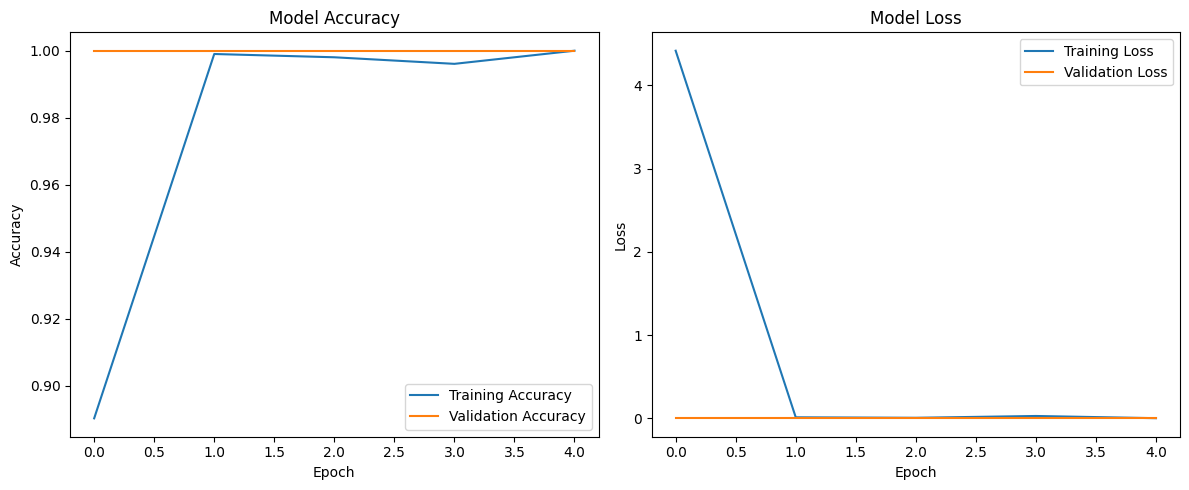

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


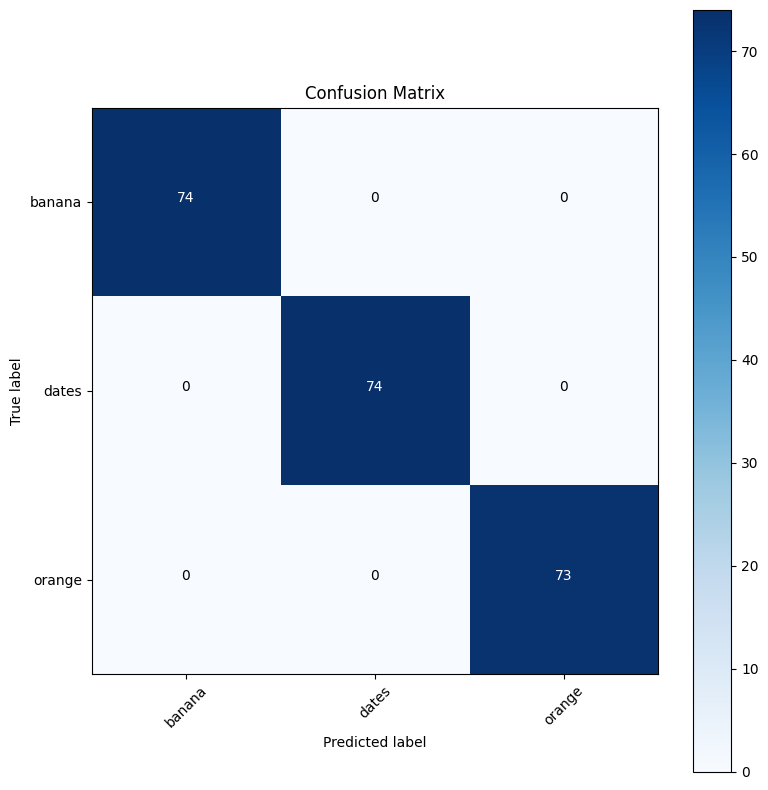


Classification Report:
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        74
       dates       1.00      1.00      1.00        74
      orange       1.00      1.00      1.00        73

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



In [8]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on the test set
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Instead of using test_ds.class_names, retrieve class_names from train_ds
class_names = train_ds.class_names

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [9]:
# Hapus folder submission jika sudah ada
if os.path.exists("submission"):
    shutil.rmtree("submission")

# 1. Buat folder utama
os.makedirs("submission", exist_ok=True)

# 2. Simpan model dalam format Keras dan SavedModel
model.save("submission/__saved_model.keras")   # format Keras (UI, preview, dll)
model.export("submission/__saved_model")       # format SavedModel (untuk TFJS)


# 3. Konversi ke TFLite dan simpan label.txt
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

os.makedirs("submission/__tflite", exist_ok=True)
with open("submission/__tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

with open("submission/__tflite/label.txt", "w") as f:
    f.write("Dates\nBanana\nOrange")

# 4. Konversi ke TensorFlow.js
!pip install tensorflowjs  # kalau belum terinstal

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --saved_model_tags=serve \
    submission/__saved_model \
    submission/__tfjs_model

# 5. Kompres folder jadi ZIP dan unduh
from google.colab import files

shutil.make_archive("submission", 'zip', "submission")
files.download("submission.zip")


Saved artifact at 'submission/__saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134564178967056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564178967824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150001936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150004048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150003280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150005392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150004816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150006160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150005584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134564150006928: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>